In [2]:
import matplotlib.pyplot as plt
# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

In [7]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# 使用刚才的数据再次训练尝试

# 1. 读取处理后的数据
df = pd.read_csv('data_processed_std.csv')


df['孕周_sq'] = df['检测孕周_周数'] ** 2
df['BMI_sq'] = df['孕妇BMI'] ** 2
df['孕周xBMI'] = df['检测孕周_周数'] * df['孕妇BMI']
df['年龄x孕周'] = df['年龄'] * df['检测孕周_周数']

# 手动设置 y 和 x 的列
y_col = 'Y染色体浓度'
# x_cols = ['检测孕周_周数','年龄','孕妇BMI','末次月经','孕周_sq','BMI_sq','孕周xBMI','年龄x孕周']
x_cols = ['检测孕周_周数','年龄','孕妇BMI','IVF妊娠','怀孕次数','生产次数']


# 根据给定的xy列，分割数据集
X = df[x_cols].values
y = df[y_col].values

# 2. 拆分训练测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. 使用xgboost

# 设置参数
param = {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}

xgb = XGBRegressor(**param)

xgb.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

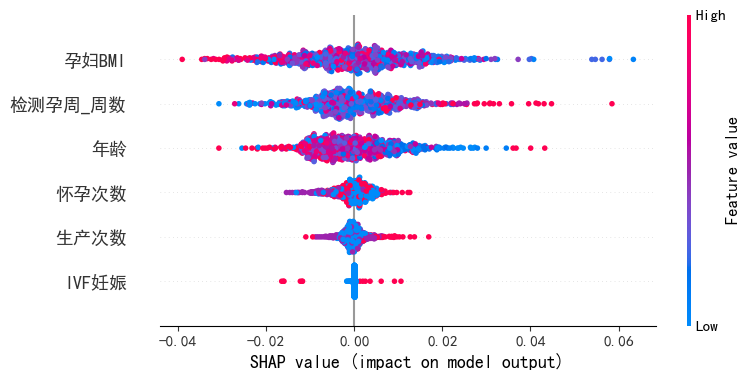

In [8]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(df[x_cols])
shap.summary_plot(shap_values, df[x_cols])

In [9]:
import numpy as np

# 基准值（phi0）
phi0 = explainer.expected_value

# 平均 SHAP 值（全局重要性方向）
mean_shap = np.mean(shap_values, axis=0)

# 生成 LaTeX 公式字符串
latex_terms = [f"{phi0:.4f}"]  # 常数项
for name, val in zip(x_cols, mean_shap):
    sign = "+" if val >= 0 else "-"
    latex_terms.append(f" {sign} {abs(val):.4f} \\cdot \\text{{{name}}}")

latex_formula = "\\hat{y} = \\sigma\\left(" + "".join(latex_terms) + "\\right)"

# 输出公式
print("LaTeX 公式：")
print(latex_formula)


LaTeX 公式：
\hat{y} = \sigma\left(0.0801 + 0.0004 \cdot \text{检测孕周_周数} - 0.0002 \cdot \text{年龄} + 0.0001 \cdot \text{孕妇BMI} - 0.0000 \cdot \text{IVF妊娠} - 0.0003 \cdot \text{怀孕次数} - 0.0001 \cdot \text{生产次数}\right)


  Feature  Importance
2      f2    0.000514
0      f0    0.000432
1      f1    0.000414
4      f4    0.000325
5      f5    0.000272
3      f3    0.000242


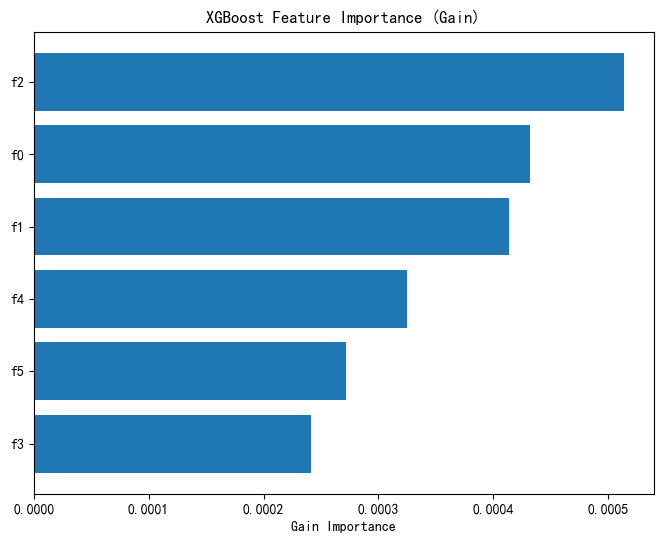

In [12]:
# 获取特征重要性（按 gain 排序）
importance_dict = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)
print(importance_df)
# 可视化
plt.figure(figsize=(8,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Gain Importance")
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [13]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_pred = xgb.predict(X_test)
# 计算r2_score
_r2_score = r2_score(y_test, y_pred)
print('r2_score:', _r2_score)

# 计算MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)



r2_score: 0.10255247390783928
MAE: 0.0240256033815061


In [14]:
# 分析xgboost对于训练集的效果
y_train_pred = xgb.predict(X_train)
print("训练集的R2得分:", r2_score(y_train, y_train_pred))


训练集的R2得分: 0.9063065753057088


Permutation-importance significance saved to regression_xgb_permutation_significance.csv


,feature,perm_importance_mean,perm_importance_std,z_score,p_value,q_value_fdr_bh,significant_0.05_fdr
0,年龄,0.158718,0.040778,3.892220,0.000099,0.000596,True
1,孕妇BMI,0.146377,0.046190,3.169045,0.001529,0.003562,True
2,检测孕周_周数,0.137334,0.043953,3.124552,0.001781,0.003562,True
3,怀孕次数,0.081710,0.027402,2.981937,0.002864,0.004296,True
4,生产次数,0.036333,0.014807,2.453677,0.014140,0.016968,True
5,IVF妊娠,0.002039,0.001132,1.802003,0.071545,0.071545,False


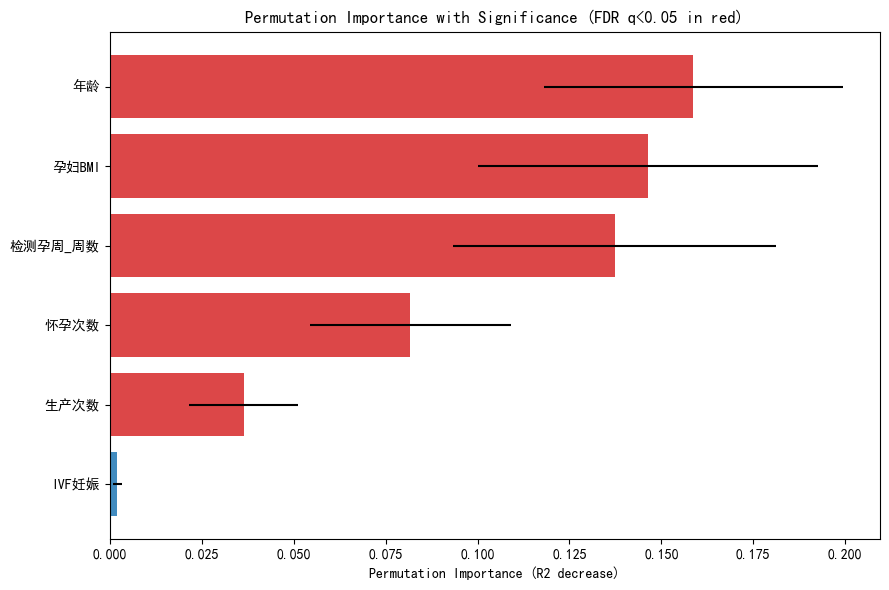

In [15]:
# English comments only inside code
# Permutation-importance based significance testing on test set
from sklearn.inspection import permutation_importance
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Baseline scoring on test set is already r2 and MAE above; here use r2 as scoring for permutation importance
# Note: Increase or decrease n_repeats according to runtime tolerance
n_repeats = 1000
result = permutation_importance(
    xgb, X_test, y_test,
    scoring="r2",
    n_repeats=n_repeats,
    random_state=42,
    n_jobs=-1
)

# Compute z-scores and p-values (two-sided) using normal approximation
imp_mean = result.importances_mean
imp_std = result.importances_std

# Avoid division by zero: where std is zero, set z to 0 and p to 1
z_scores = np.zeros_like(imp_mean)
nonzero = imp_std > 1e-12
z_scores[nonzero] = imp_mean[nonzero] / imp_std[nonzero]

p_values = np.ones_like(imp_mean)
p_values[nonzero] = 2 * (1 - norm.cdf(np.abs(z_scores[nonzero])))

# FDR control (Benjamini-Hochberg)
try:
    from statsmodels.stats.multitest import multipletests
    rejected, q_values, _, _ = multipletests(p_values, alpha=0.05, method="fdr_bh")
except Exception as e:
    # If statsmodels not available, fall back to no-adjustment q-values
    print("statsmodels not available; using raw p-values as q-values. Error:", e)
    rejected = p_values < 0.05
    q_values = p_values

# Build results DataFrame with feature names
perm_sig_df = pd.DataFrame({
    "feature": x_cols,
    "perm_importance_mean": imp_mean,
    "perm_importance_std": imp_std,
    "z_score": z_scores,
    "p_value": p_values,
    "q_value_fdr_bh": q_values,
    "significant_0.05_fdr": rejected
}).sort_values(by="perm_importance_mean", ascending=False).reset_index(drop=True)

# Save to CSV
perm_sig_df.to_csv("regression_xgb_permutation_significance.csv", index=False)
print("Permutation-importance significance saved to regression_xgb_permutation_significance.csv")
display(perm_sig_df)

# Plot with significance highlighting
plt.figure(figsize=(9, 6))
colors = ["#d62728" if sig else "#1f77b4" for sig in perm_sig_df["significant_0.05_fdr"]]
plt.barh(perm_sig_df["feature"], perm_sig_df["perm_importance_mean"], xerr=perm_sig_df["perm_importance_std"], color=colors, alpha=0.85)
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (R2 decrease)")
plt.title("Permutation Importance with Significance (FDR q<0.05 in red)")
plt.tight_layout()
plt.show()

C:\Users\heerh\AppData\Local\Temp\ipykernel_22564\3780323458.py:45: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
s:\academic_codes\sxjm-2025-school\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


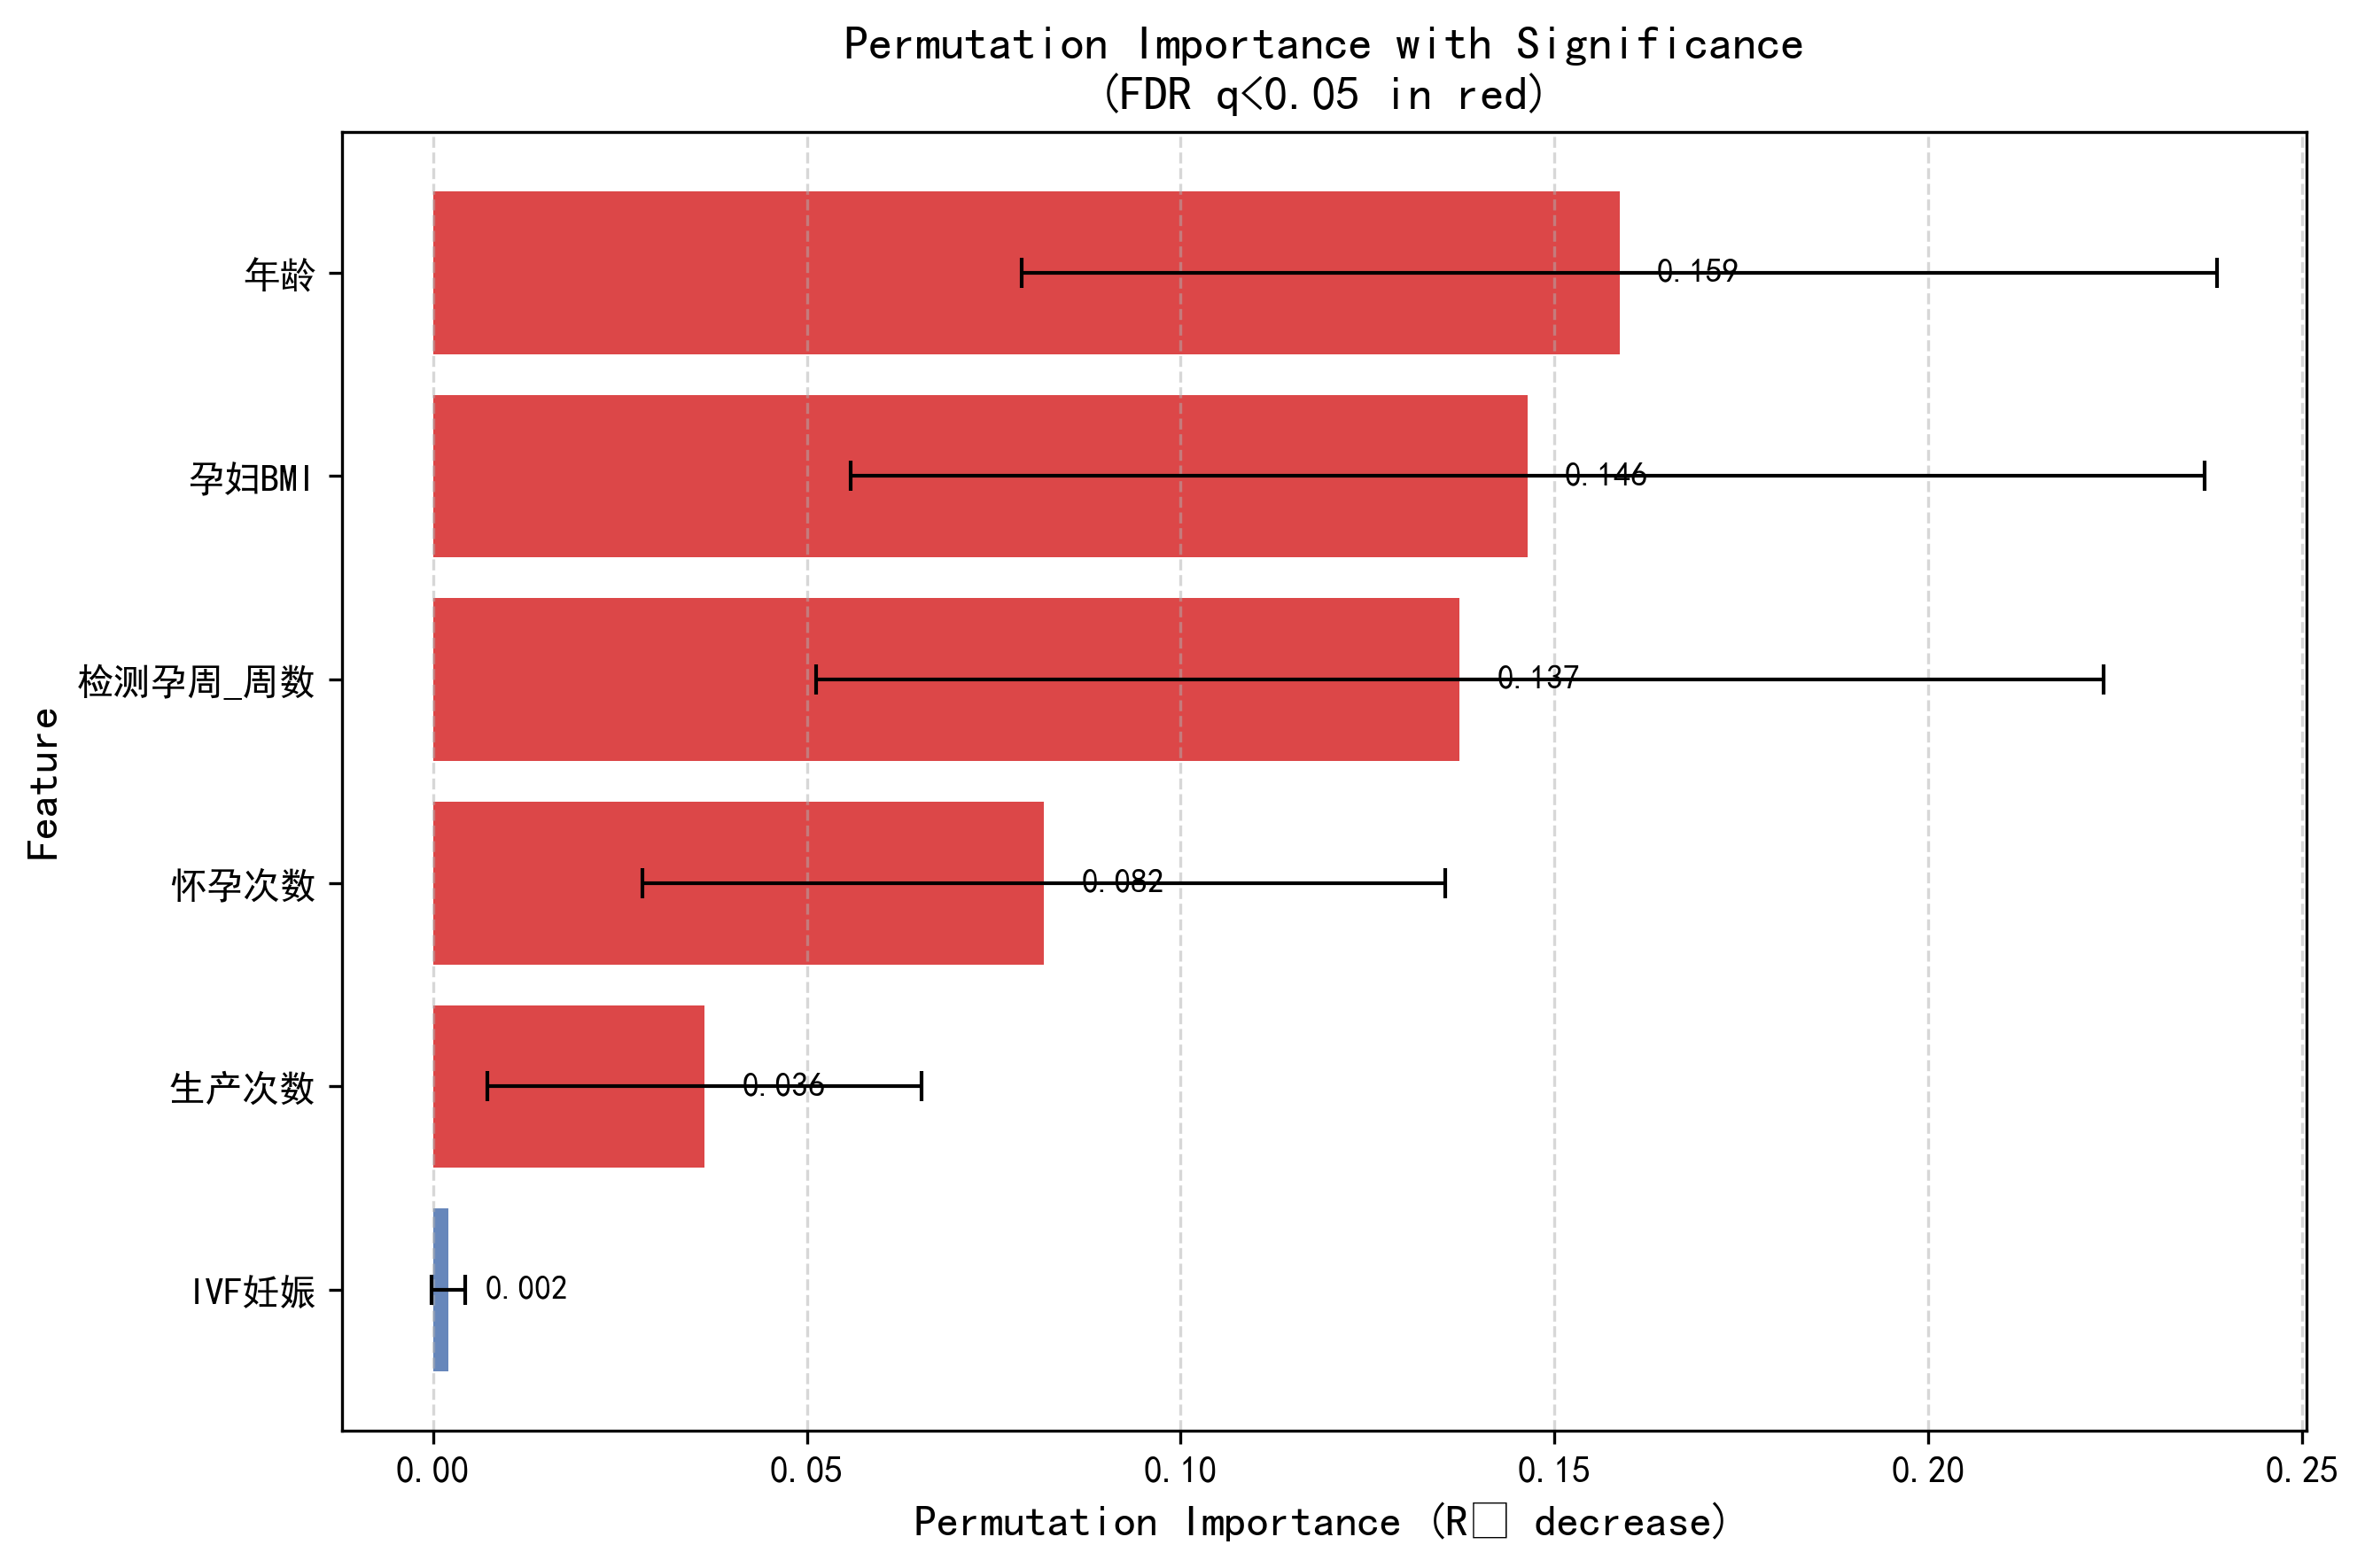

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 计算 95% CI
ci95 = 1.96 * perm_sig_df["perm_importance_std"]

# 颜色映射
colors = ["#d62728" if sig else "#4c72b0" 
          for sig in perm_sig_df["significant_0.05_fdr"]]

# 绘图
plt.figure(figsize=(9, 6), dpi=300)
bars = plt.barh(
    perm_sig_df["feature"],
    perm_sig_df["perm_importance_mean"],
    xerr=ci95,
    color=colors,
    alpha=0.85,
    capsize=4,
    ecolor='black',
    error_kw={'elinewidth':1}
)

# 数值标注（均值）
for bar, value in zip(bars, perm_sig_df["perm_importance_mean"]):
    plt.text(
        bar.get_width() + 0.005,  # 位置稍微右移
        bar.get_y() + bar.get_height()/2,
        f"{value:.3f}",
        va='center',
        fontsize=9
    )

# 坐标轴与标题
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (R² decrease)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Permutation Importance with Significance\n(FDR q<0.05 in red)", fontsize=13, weight='bold')

# 网格与边框
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tick_params(axis='both', labelsize=10)

# 紧凑布局
plt.tight_layout()
plt.show()
